In [ ]:
!pip3 install jams
!pip install matplotlib
!pip install audiolazy
!pip install librosa
!pip3 install music21
!pip3 install MIDIUtil

In [1]:
import numpy as np
import os
import pprint

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, hinge_loss

import scipy.io.wavfile as wav
import jams

import librosa
import audiolazy as al

import music21
from midiutil import MIDIFile

## Processing Data Input (Guitar Dataset)

In [2]:
def timeKey(t):
    return t[0]

def loadNoteData(f):
    #f = open('/content/JamsFiles/04_Rock1-90-C_solo.jams', 'r')

   # data = f.read()
    data = jams.load(f)
    notes = []

    for i in range (0, 6):
        for j in data.annotations["note_midi"][i]["data"]:
            notes.append([j[0],j[1],j[2]])
            
    notes.sort(key=timeKey)

    #pprint.pprint(notes)
    return notes

In [3]:
def load_audio_file(song_path, scale = False):
    srate, source_audio = wav.read(song_path)
    if scale:
        source_audio = source_audio.astype(np.float32) / max(max(source_audio),abs(min(source_audio)))

    return source_audio, srate

In [4]:
#function to process the raw audio data.
def x_data_process(raw_data):
    scaler = preprocessing.MinMaxScaler((-1,1))
    scaled = scaler.fit_transform(raw_data)
    return scaled

In [5]:
#TODO: Change this so it pads to match the shape of frame. not just the length
def pad(proper_size, frame):
    padsize = winSize-len(frame)
    temp = None
    if len(frame.shape) > 1:
        temp = np.zeros((frame.shape[0],padsize))
    else:
        temp = np.zeros(padsize)

    return np.concatenate((frame,temp))

In [6]:
def songProcess(song_audio,notes,sr,hopSize = 1024,winSize = 4096,features = [],labels = []):

  testCount = 0

  offsets = np.arange(0,len(song_audio),hopSize)
  for (i,o) in enumerate(offsets):
    testCount += 1

    original_frame_size = 0

    frame = audio[o:o+winSize]

    if original_frame_size == 0:
      original_frame_size = frame.shape

    note = 0
    tiebreak = []

    #Create labels from jams file data -- if multiple notes in frame, take longest duration
    for j,(time,duration,value) in enumerate(notes):
      note_start = time*sr
      note_end = (time+duration)*sr
      if o <= note_start < o+winSize:                 #note starts in frame
        tiebreak.append(j)
      elif o <= note_end < o+winSize:                  #note ends in frame
        tiebreak.append(j)
      elif note_start < o and o+winSize <= note_end: #note continuous thru frame
        note = value

    #if multiple notes in frame, choose one that played the longest in frame
    if len(tiebreak) > 0:
      if len(tiebreak) == 1:
        note = notes[tiebreak[0]][2]
      else:
        max_dur = 0
        max_note = 0
        for index in tiebreak:
          note_start = notes[index][0] * sr
          note_duration = notes[index][1] * sr
          frame_dur = 0
          if note_start < o:
            frame_dur = note_duration+note_start-o
          elif note_start+note_duration > o+winSize:
            frame_dur = o+winSize - note_start
          else:
            frame_dur = note_duration

          if frame_dur > max_dur:
            max_dur = frame_dur
            max_note = notes[index][2]
        note = max_note


    #pad feature matrix
    if len(frame) < winSize:
      frame = pad(winSize, frame)

    #append to feature and labels
    features.append(frame)
    labels.append(round(note))  #quantize to the nearest midi value

  return features,labels,testCount

In [7]:
def tsneFit(X, comps):
    tsne = TSNE(comps, learning_rate='auto', init='pca')
    result = tsne.fit_transform(X)
    return result

## Predict Function

In [8]:
"""Taking the song path, trained model, and same hopSize and winSize as used in training,
Converts song into predicted midi information"""
def predict(song_path, model, hopSize, winSize):
    
    audio,sr = load_audio_file(song_path, scale=False)
    offsets = np.arange(0,len(audio),hopSize)
    x_data = []
    for (i,o) in enumerate(offsets):
        frame = audio[o:o+winSize]
        #pad
        if len(frame) < winSize:
            frame = pad(winSize, frame)

        #append to features
        x_data.append(frame)

    #preprocess data
    x_data = x_data_process(x_data)

    #column 0 is note, column 1 is time
    midi_info = np.zeros((len(offsets),2))
    raw_results = model.predict(x_data)

    for i,frame_note in enumerate(raw_results):
        midi_info[i][0] = frame_note
        midi_info[i][1] = hopSize*i/sr

        #TODO: create proper midi file from this note / time information
          #Also determine method to covert midi into sheet music

    return midi_info

## Coverting predicted MIDI info into MIDI file and Note Sheet


In [9]:
def to_midi_sheet(midi_info,outfile):
    degrees = []

    for note, time in midi_info:
        if note != 0.0:
            degrees.append(int(note))

    track    = 0
    channel  = 0
    time     = 0    # In beats
    duration = 1    # In beats
    tempo    = 120   # In BPM
    volume   = 100  # 0-127, as per the MIDI standard

    MyMIDI = MIDIFile(1)  # One track
    MyMIDI.addTempo(track, time, tempo)

    for i, pitch in enumerate(degrees):
        MyMIDI.addNote(track, channel, pitch, time + i, duration, volume)

    with open(outfile + '.mid', "wb") as output_file:
        MyMIDI.writeFile(output_file)

    parsed = music21.converter.parse(outfile + '.mid')
    # parsed.show('musicxml.png')

## Driver to load data and # of songs

In [10]:
# LOAD SONG AND JAM FILES
song_path = r'DataSets/audio_mono-mic'
jam_path = r'DataSets/annotation'
MODE = 'solo'
inputFiles = list(zip([x for x in os.listdir(song_path) if MODE in x],[x for x in os.listdir(jam_path) if MODE in x]))

In [18]:
##Set up features and labels for ML
numSongs = 15
counter = numSongs

notecounter = 0

hopSize = 1024
winSize = 1024

XData,YData = [],[]
XData_pre,YData_pre = [],[]
for song_file,jam_file in inputFiles:
    song = os.path.join(song_path,song_file)
    jam = os.path.join(jam_path,jam_file)
    
    audio,sr = load_audio_file(song, scale=False)
    note_info = loadNoteData(jam)

    # Can pass in a feature matrix and label array if we want to concat multiple songs together
    XData,YData,notecount = songProcess(audio,note_info,sr, hopSize, winSize)

    #Prescaled Xdata for experiement
    audio_prescaled,sr = load_audio_file(song,scale=True)
    XData_pre,YData_pre,notecount = songProcess(audio_prescaled,note_info,sr,hopSize,winSize)

    notecounter += notecount
    counter -= 1
    if counter == 0:
        break

## Neural Network Model Testing

In [12]:
def neural_network(XTrain, XTest, YTrain, YTest, hidden_size, max_iter, solver, activation):
    #Currently, using successful values from A1, further adjustment with the processed dataset will be needed
    MLPC = MLPClassifier(hidden_layer_sizes=hidden_size, max_iter=max_iter, alpha=0.0001, 
                         learning_rate_init=0.001, solver=solver, activation=activation)
    MLPC.fit(XTrain, YTrain)
    
    training_score = MLPC.score(XTrain, YTrain)
    test_score = MLPC.score(XTest, YTest)
    
    train_predict = MLPC.predict(XTrain)
    train_error = mean_squared_error(YTrain, train_predict)

    test_predict = MLPC.predict(XTest)
    test_error = mean_squared_error(YTest, test_predict)
    
    print("Training Accuracy:", training_score)
    print("Test Accuracy:", test_score)
    print("Error for Training:", train_error)
    print("Error for Testing:", test_error)
    
    
    return MLPC

In [13]:
def neural_network_2(XTrain, XTest, YTrain, YTest, num_hidden_layer, max_iter, solver, activation):
    
    # This will contain all neural networks
    clfs = []
    # Running model 
    # This will be used to play with fitting the best neural network with hidden layer size n
    hidden_layer_size = list(range(1, num_hidden_layer)) # contains all num of the hidden layer sizes from 1 to num_hidden_layer
    for layer_size in hidden_layer_size:
        clf = MLPClassifier(random_state=0, hidden_layer_sizes=layer_size, solver=solver, 
                            max_iter=max_iter, activation=activation)
        clf.fit(XTrain, YTrain)
        clfs.append(clf)
    
    # Now getting the scores from the run models
    training_scores = [clf.score(XTrain, YTrain) for clf in clfs]
    test_scores = [clf.score(XTest, YTest) for clf in clfs]
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Number of Hidden Layers")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy vs Number of Hidden Layers")
    ax.plot(hidden_layer_size, training_scores, marker='o', label="train")
    ax.plot(hidden_layer_size, test_scores, marker='o', label="test")
    ax.legend()
    
    # For my analysis I want to find the best tree, aka the one with the best test score
    best_layer_size = test_scores.index(max(test_scores))
    # Then I can find the accruacy and depth of this tree
    bestAccuracy = test_scores[best_layer_size]
    best_hidden_layer_size = hidden_layer_size[best_layer_size]
    
    print("Highest Accuracy:",bestAccuracy, "Hidden Layer Size:",best_hidden_layer_size)

Highest Accuracy: 0.3368592351505289 Hidden Layer Size: 77
CPU times: user 59min 48s, sys: 6min 13s, total: 1h 6min 1s
Wall time: 16min 47s


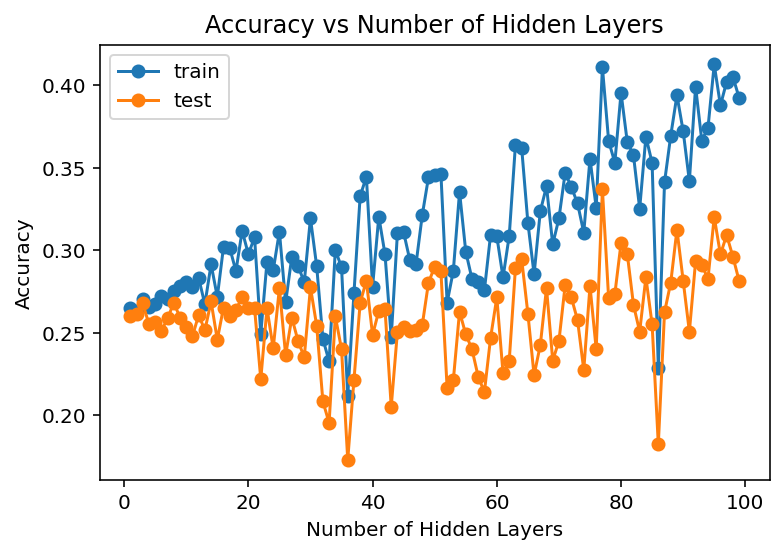

In [23]:
%%time
# NN Using No Scaling

XTrain,XTest,YTrain,YTest = train_test_split(XData,YData,test_size=0.2)
hidden_size=100
max_iter=10000
solver='adam'
activation='relu'
NN_1 = neural_network_2(XTrain,XTest,YTrain,YTest,hidden_size, max_iter, solver, activation)


In [21]:
%%time

XData_local = x_data_process(XData)
XDataTSNE = tsneFit(XData_local, 2)

XTrain,XTest,YTrain,YTest = train_test_split(XDataTSNE,YData,test_size=0.2)

hidden_size=(77,120)
max_iter=10000
solver='adam'
activation='tanh'
NN_1 = neural_network(XTrain,XTest,YTrain,YTest,hidden_size, max_iter, solver, activation)

/Users/shawnnettleton/opt/miniconda3/envs/apress/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Training Accuracy: 0.40155854808941144
Test Accuracy: 0.3693880898999289
Error for Training: 1587.4820972041834
Error for Testing: 1645.8918904139553
CPU times: user 1h 9min 33s, sys: 5min 23s, total: 1h 14min 56s
Wall time: 16min


In [ ]:
%%time
# NN Using Post Scaling
XData_postscaled = x_data_process(XData)

XTrain,XTest,YTrain,YTest = train_test_split(XData_postscaled,YData,test_size=0.2)
hidden_size=(77,120)
max_iter=100000
solver='adam'
activation='tanh'
NN_2_accuracy, NN_2 = neural_network(XTrain,XTest,YTrain,YTest,hidden_size, max_iter, solver, activation)
print("NN Model Test Accuracy:",NN_2_accuracy)

In [28]:
%%time
# NN Using Pre Scaling
XData_pre = np.array(XData_pre)
XData_pre = XData_pre / max(XData_pre.max(), abs(XData_pre.min()))

XTrain,XTest,YTrain,YTest = train_test_split(XData_pre,YData_pre,test_size=0.2)
hidden_size=(60,120)
max_iter=10000
solver='adam'
activation='tanh'
NN_3_accuracy, NN_3 = neural_network(XTrain,XTest,YTrain,YTest,hidden_size, max_iter, solver, activation)
print("NN Model Test Accuracy:",NN_3_accuracy)

NN Model Test Accuracy: 0.9828726845045574
CPU times: user 1h 1min 53s, sys: 6min 31s, total: 1h 8min 25s
Wall time: 17min 39s


In [78]:
%%time
# NN Using TSNE Scaling
XData_local = x_data_process(XData)
XDataTSNE = tsneFit(XData_local, 2)

XTrain,XTest,YTrain,YTest = train_test_split(XDataTSNE,YData,test_size=0.2)
hidden_size=(60,120)
max_iter=10000
solver='adam'
activation='tanh'
NN_4_accuracy, NN_4 = neural_network(XTrain,XTest,YTrain,YTest,hidden_size, max_iter, solver, activation)
print("NN Model Test Accuracy:",NN_4_accuracy)

/Users/shawnnettleton/opt/miniconda3/envs/apress/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


NN Model Test Accuracy: 0.2957689178193653
CPU times: user 7min 2s, sys: 26.5 s, total: 7min 29s
Wall time: 1min 25s


### NN Results 

After the above test cases we found the Pre Scaling method for the data to perform the best for the Neural Network

## Support Vector Machine Model Testing

In [12]:
def gaussianSVM(XTrain, XTest, YTrain, YTest):
    #Currently, using successful values from A2, further adjustment with the processed dataset will be needed
    clf = SVC(kernel = 'rbf', gamma = 0.01, C = 150, max_iter=100000)
    clf.fit(XTrain, YTrain)
    

    return accuracy_score(YTest, clf.predict(XTest)), clf

In [13]:
def polySVM(XTrain, XTest, YTrain, YTest):
    #Currently, using successful values from A2, further adjustment with the processed dataset will be needed
    clf = SVC(kernel = 'poly', gamma = 0.01, C = 150, max_iter=100000)
    clf.fit(XTrain, YTrain)

    return accuracy_score(YTest, clf.predict(XTest)), clf

In [14]:
def gaussianSVM_2(XTrain, XTest, YTrain, YTest):
    #Currently, using successful values from A2, further adjustment with the processed dataset will be needed
    clf = SVC(kernel = 'rbf', gamma = 0.01, C = 150, max_iter=100000)
    clf.fit(XTrain, YTrain)
    
    training_score = clf.score(XTrain, YTrain)
    test_score = clf.score(XTest, YTest)
    
    train_predict = clf.predict(XTrain)
    train_error = mean_squared_error(YTrain, train_predict)

    test_predict = clf.predict(XTest)
    test_error = mean_squared_error(YTest, test_predict)
    
    print("Training Accuracy:", training_score)
    print("Test Accuracy:", test_score)
    print("Error for Training:", train_error)
    print("Error for Testing:", test_error)
    

    return clf

### RBF Kernel - Gaussian SVM Testing

In [ ]:
%%time
XTrain,XTest,YTrain,YTest = train_test_split(XData,YData,test_size=0.2)


GSVM_1 = gaussianSVM_2(XTrain,XTest,YTrain,YTest)


In [ ]:
%%time
XData_postscaled = x_data_process(XData)

XTrain,XTest,YTrain,YTest = train_test_split(XData_postscaled,YData,test_size=0.2)
GSVM3 = gaussianSVM_2(XTrain,XTest,YTrain,YTest)

In [19]:
XData_local = x_data_process(XData)
XDataTSNE = tsneFit(XData_local, 2)

XTrain,XTest,YTrain,YTest = train_test_split(XDataTSNE,YData,test_size=0.2)
GSVM3 = gaussianSVM_2(XTrain,XTest,YTrain,YTest)

/Users/shawnnettleton/opt/miniconda3/envs/apress/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/shawnnettleton/opt/miniconda3/envs/apress/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Accuracy: 0.6902942404385471
Test Accuracy: 0.6063312277644667
Error for Training: 821.88181372638
Error for Testing: 1004.362956509112


In [ ]:
%%time
# RBF Kernel - No Scaling

XTrain,XTest,YTrain,YTest = train_test_split(XData,YData,test_size=0.2)
GSVM_1_accuracy, GSVM_1 = gaussianSVM(XTrain,XTest,YTrain,YTest)
print("Gaussian SVM Model Test Accuracy:",GSVM_1_accuracy)

In [82]:
%%time
# RBF Kernel - Post Scaling
XData_postscaled = x_data_process(XData)

XTrain,XTest,YTrain,YTest = train_test_split(XData_postscaled,YData,test_size=0.2)
GSVM_2_accuracy, GSVM_2 = gaussianSVM(XTrain,XTest,YTrain,YTest)
print("Gaussian SVM Model Test Accuracy:",GSVM_2_accuracy)

/Users/shawnnettleton/opt/miniconda3/envs/apress/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Gaussian SVM Model Test Accuracy: 0.42799023596419855
CPU times: user 1min 30s, sys: 267 ms, total: 1min 31s
Wall time: 1min 31s


In [83]:
%%time
# RBF Kernel - Pre Scaling
XData_pre = np.array(XData_pre)
XData_pre = XData_pre / max(XData_pre.max(), abs(XData_pre.min()))

XTrain,XTest,YTrain,YTest = train_test_split(XData_pre,YData_pre,test_size=0.2)
GSVM_3_accuracy, GSVM3 = gaussianSVM(XTrain,XTest,YTrain,YTest)
print("Gaussian SVM Model Test Accuracy:",GSVM_3_accuracy)

Gaussian SVM Model Test Accuracy: 0.43816110659072416
CPU times: user 1min 36s, sys: 344 ms, total: 1min 36s
Wall time: 1min 36s


In [84]:
%%time
# RBF Kernel - TSNE Scaling
XData_local = x_data_process(XData)
XDataTSNE = tsneFit(XData_local, 2)

XTrain,XTest,YTrain,YTest = train_test_split(XDataTSNE,YData,test_size=0.2)
GSVM_4_accuracy, GSVM_4 = gaussianSVM(XTrain,XTest,YTrain,YTest)
print("Gaussian SVM Model Test Accuracy:",GSVM_4_accuracy)

/Users/shawnnettleton/opt/miniconda3/envs/apress/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Gaussian SVM Model Test Accuracy: 0.5935720097640358
CPU times: user 4min 58s, sys: 5.58 s, total: 5min 4s
Wall time: 51.2 s


### Poly Kernel - Polynomial SVM Testing

In [85]:
%%time
# Poly Kernel - No Scaling

XTrain,XTest,YTrain,YTest = train_test_split(XData,YData,test_size=0.2)
PSVM_1_accuracy, PSVM_1 = polySVM(XTrain,XTest,YTrain,YTest)
print("Poly SVM Model Test Accuracy:",PSVM_1_accuracy)

/Users/shawnnettleton/opt/miniconda3/envs/apress/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Poly SVM Model Test Accuracy: 0.48942229454841335
CPU times: user 2min 21s, sys: 316 ms, total: 2min 21s
Wall time: 2min 21s


In [86]:
%%time
# Poly Kernel - Post Scaling
XData_postscaled = x_data_process(XData)

XTrain,XTest,YTrain,YTest = train_test_split(XData_postscaled,YData,test_size=0.2)
PSVM_2_accuracy, PSVM_2 = polySVM(XTrain,XTest,YTrain,YTest)
print("Poly SVM Model Test Accuracy:",PSVM_2_accuracy)

Poly SVM Model Test Accuracy: 0.3698128559804719
CPU times: user 1min 19s, sys: 251 ms, total: 1min 19s
Wall time: 1min 19s


In [87]:
%%time
# Poly Kernel - Pre Scaling
XData_pre = np.array(XData_pre)
XData_pre = XData_pre / max(XData_pre.max(), abs(XData_pre.min()))

XTrain,XTest,YTrain,YTest = train_test_split(XData_pre,YData_pre,test_size=0.2)
PSVM_3_accuracy, PSVM_3 = polySVM(XTrain,XTest,YTrain,YTest)
print("Poly SVM Model Test Accuracy:",PSVM_3_accuracy)

Poly SVM Model Test Accuracy: 0.36126932465419037
CPU times: user 1min 25s, sys: 249 ms, total: 1min 25s
Wall time: 1min 25s


In [88]:
%%time
# Poly Kernel - TSNE Scaling
XData_local = x_data_process(XData)
XDataTSNE = tsneFit(XData_local, 2)

XTrain,XTest,YTrain,YTest = train_test_split(XDataTSNE,YData,test_size=0.2)
PSVM_4_accuracy, PSVM_4 = polySVM(XTrain,XTest,YTrain,YTest)
print("Poly SVM Model Test Accuracy:",PSVM_4_accuracy)

/Users/shawnnettleton/opt/miniconda3/envs/apress/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/shawnnettleton/opt/miniconda3/envs/apress/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Poly SVM Model Test Accuracy: 0.04271765663140765
CPU times: user 6min 21s, sys: 7.66 s, total: 6min 29s
Wall time: 2min 28s


### SVM Model Results

Having run the different scaling methods on both a Gaussian SVM and Polynomial SVM we found the best model was the Gaussian. The best scaling method was also no scaling.

In [31]:
song = 'DataSets/audio_mono-mic/00_Funk3-98-A_solo_mic.wav'
hopSize = 1024
winSize = 1024
midi_info = predict(song,NN_3,hopSize,winSize)
to_midi_sheet(midi_info,outfile="nn_sheet_music")